In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
# This is need so you can import larndsim without doing python setup.py install
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,'/sdf/home/s/sgaz/larnd-sim/')

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import mpl_toolkits.mplot3d.art3d as art3d

import numpy as np
import eagerpy as ep
import h5py

import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 100
import pickle

In [4]:
from numpy.lib import recfunctions as rfn
import torch

def torch_from_structured(tracks):
    tracks_np = rfn.structured_to_unstructured(tracks, copy=True, dtype=np.float32)
    return torch.from_numpy(tracks_np).float()

def structered_from_torch(tracks_torch, dtype):
    return rfn.unstructured_to_structured(tracks_torch.cpu().numpy(), dtype=dtype)

### Dataset import
First of all we load the `edep-sim` output. For this sample we need to invert $z$ and $y$ axes.

In [5]:
# If you have access to a GPU, sim works trivially/is much faster
if torch.cuda.is_available():
    device = 'cuda'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'

In [6]:
dir_name = '/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim-output.h5'
fname = dir_name
with h5py.File(fname, 'r') as f:
    tracks = np.array(f['segments'])  

x_start = np.copy(tracks['x_start'] )
x_end = np.copy(tracks['x_end'])
x = np.copy(tracks['x'])

tracks['x_start'] = np.copy(tracks['z_start'])
tracks['x_end'] = np.copy(tracks['z_end'])
tracks['x'] = np.copy(tracks['z'])

tracks['z_start'] = x_start
tracks['z_end'] = x_end
tracks['z'] = x

In [7]:
index = {}
all_events = np.unique(tracks['eventID'])
for ev in all_events:
    track_set = np.unique(tracks[tracks['eventID'] == ev]['trackID'])
    index[ev] = track_set  

In [8]:
def batch(index, tracks, size=10, max_seg=-1):
    n_seg = 0
    out_trk = []
    while n_seg < size:
        rand_ev = np.random.choice(list(index.keys()))
        rand_track = np.random.randint(0, len(index[rand_ev]))
        mask = (tracks['eventID']== rand_ev) & (tracks['trackID'] == index[rand_ev][rand_track])
        n_seg += np.sum(mask)
        
        out_trk.append(torch_from_structured(tracks[mask].copy()))
       
    out = torch.cat(out_trk, dim=0)
    if max_seg != -1 and len(out) > max_seg:
        idxs = np.random.permutation(np.arange(max_seg))
        return out[idxs]
    else:
        return out

## Simulation
To flexibly keep track of parameters/gradients, simulations are housed in a class `sim_with_grad`. This is derived from class versions of all the other modules. Parameters are housed in `consts`, with method `track_gradients` to promote the constants to `requires_grad=True` PyTorch tensors.

In [9]:
from larndsim.sim_with_grad import sim_with_grad

Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.pixel_trim_dac using bits (0, 512)
	<function _list_property at 0x7fee20d9f3a0>((<class 'int'>, 0, 31, 64, 8)) 
Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.threshold_global using bits (512, 520)
	<function _basic_property at 0x7fee20d9f310>((<class 'int'>, 0, 255)) 
Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.csa_gain using bits (520, 521)
	<function _compound_property at 0x7fee20d9f430>((['csa_gain', 'csa_bypass_enable', 'bypass_caps_en'], (<class 'int'>, <class 'bool'>), 0, 1)) 
Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.csa_bypass_enable using bits (521, 522)
	<function _compound_property at 0x7fee20d9f430>((['csa_gain', 'csa_bypass_enable', 'bypass_caps_en'], (<class 'int'>, <class 'bool'>), 0, 1)) 
Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.bypass_caps_en using bits (522, 523)
	

## The simulation
Following the flow of the simulation chain, define a function which takes in the `sim_with_grad` object, runs whatever pieces of the simulation, and returns desired output.

In [10]:
def get_id_map(selected_tracks, fields):
    # Here we build a map between tracks and event IDs (no param dependence, so np should be ok)
    unique_eventIDs = np.unique(selected_tracks[:, fields.index('eventID')])
    event_id_map = np.searchsorted(unique_eventIDs,np.asarray(selected_tracks[:, fields.index('eventID')]))
    event_id_map_torch = torch.from_numpy(event_id_map).to(device)
    
    return event_id_map_torch, unique_eventIDs

In [11]:
def all_sim(sim, selected_tracks, fields, event_id_map, unique_eventIDs, return_unique_pix=False):
    selected_tracks_quench = sim.quench(selected_tracks, sim.birks, fields=fields)
    selected_tracks_drift = sim.drift(selected_tracks_quench, fields=fields)

    active_pixels_torch, neighboring_pixels_torch, n_pixels_list_ep = sim.get_pixels(selected_tracks_drift,
                                                                                     fields=fields)

    track_starts_torch, max_length_torch = sim.time_intervals(event_id_map, 
                                                              selected_tracks_drift, 
                                                              fields=fields)
    
    signals_ep = sim.tracks_current(neighboring_pixels_torch, selected_tracks_drift, 
                                          max_length_torch,
                                          fields=fields)

    unique_pix_torch = torch.empty((0, 2))
    pixels_signals_torch = torch.zeros((len(unique_pix_torch), len(sim.time_ticks)*50))

    shapes_torch = neighboring_pixels_torch.shape
    joined_torch = neighboring_pixels_torch.reshape(shapes_torch[0]*shapes_torch[1], 2)

    this_unique_pix_torch = torch.unique(joined_torch, dim=0)
    this_unique_pix_torch = this_unique_pix_torch[(this_unique_pix_torch[:,0] != -1) & (this_unique_pix_torch[:,1] != -1),:]
    unique_pix_torch = torch.cat((unique_pix_torch, this_unique_pix_torch),dim=0)

    this_pixels_signals_torch = torch.zeros((len(this_unique_pix_torch), len(sim.time_ticks)*50))
    pixels_signals_torch = torch.cat((pixels_signals_torch, this_pixels_signals_torch), dim=0)

    pixel_index_map_torch = torch.full((selected_tracks.shape[0], neighboring_pixels_torch.shape[1]), -1)
    compare_torch = (neighboring_pixels_torch[..., np.newaxis, :] == unique_pix_torch)

    indices_torch = torch.where(torch.logical_and(compare_torch[..., 0], compare_torch[...,1]))
    pixel_index_map_torch[indices_torch[0], indices_torch[1]] = indices_torch[2]
    
    pixels_signals_torch = sim.sum_pixel_signals(pixels_signals_torch,
                                                 signals_ep,
                                                track_starts_torch,
                                                pixel_index_map_torch)
    
    time_ticks_torch = torch.linspace(0, len(unique_eventIDs)*sim.time_interval[1]*3, pixels_signals_torch.shape[1]+1)

    integral_list_torch, adc_ticks_list_torch = sim.get_adc_values(pixels_signals_torch,
                                                                   time_ticks_torch,
                                                                   0)
    adc_list_torch = sim.digitize(integral_list_torch)

    if return_unique_pix:
        return adc_list_torch, unique_pix_torch,
    else:
        return adc_list_torch

In [12]:
# Update parameters for training loop
def update_grad_param(sim, name, value):
    setattr(sim, name, value)
    sim.track_gradients([name])

In [13]:
# ADC counts given as list of pixels. Better for loss to embed this in the "full" pixel space
def embed_adc_list(sim, adc_list, unique_pix):
    zero_val = sim.digitize(torch.tensor(0)).item()
    new_list = torch.ones((sim.n_pixels[0], sim.n_pixels[1], adc_list.shape[1]))*zero_val

    plane_id = unique_pix[..., 0] // sim.n_pixels[0]
    unique_pix[..., 0] = unique_pix[..., 0] - sim.n_pixels[0] * plane_id

    new_list[unique_pix[:, 0].long(), unique_pix[:, 1].long(), :] = adc_list
    
    return new_list

## Define dict with ranges from the spreadsheet
https://docs.google.com/spreadsheets/d/1DLpSDgPsHeHUWCEBayYCcbLzIzd30vfBe72N-Z5vWTc/edit#gid=1247026028

In [14]:
ranges = {}
ranges['lArDensity']     = {'nom': 1.38, 'down': 1.37, 'up': 1.41}
ranges['eField']         = {'nom': 0.5, 'down': 0.45, 'up': 0.55}
ranges['vdrift']         = {'nom': 0.1648, 'down': 0.1400, 'up': 0.1800}
ranges['MeVToElectrons'] = {'nom': 4.24e4, 'down': 3.48e4, 'up': 5.13e4}
ranges['alpha']          = {'nom': 0.93, 'down': 0.85, 'up': 1.1}
ranges['beta']           = {'nom': 0.207, 'down': 0.18, 'up': 0.22}
ranges['Ab']             = {'nom': 0.8, 'down': 0.78, 'up': 0.88}
ranges['kb']             = {'nom': 0.0486, 'down': 0.04, 'up': 0.07}
ranges['lifetime']       = {'nom': 2.2e3, 'down': 300, 'up': 3e4}
ranges['long_diff']      = {'nom': 4.0e-6, 'down': 2e-6, 'up': 9e-6}
ranges['tran_diff']      = {'nom': 8.8e-6, 'down': 4e-6, 'up': 14e-6}

In [15]:
def param_l2_reg(param, sim):
    sigma = (ranges[param]['up'] - ranges[param]['down'])/2.
    return ((ranges[param]['nom']-getattr(sim, param))**2)/(sigma**2)

In [16]:
def calc_reg_loss(param_list, sim, regs):
    reg_loss = 0.
    for param in param_list:
        reg_loss+=regs[param]*param_l2_reg(param, sim)
        
    return reg_loss

In [17]:
#Simulate with some set:
sim_target = sim_with_grad(track_chunk=1, pixel_chunk=1)
sim_target.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")

In [18]:
relevant_params = ['eField', 'lifetime', 'Ab', 'kb']

In [19]:
#Setup simulation object for training -- params initialized to defaults
sim = sim_with_grad(track_chunk=1, pixel_chunk=1)
sim.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")

sim.track_gradients(relevant_params)

## Instead of varying all params by hand, draw randomly in range
These are used as the targets

In [20]:
np.random.seed(2)
for param in relevant_params:
    param_val = np.random.uniform(low=ranges[param]['down'], 
                                      high=ranges[param]['up'])
    
    setattr(sim_target, param, param_val)

In [21]:
for param in relevant_params:
    print(f'{param}, target: {getattr(sim_target, param)}, init {getattr(sim, param).item()}')

eField, target: 0.4935994902142004, init 0.5
lifetime, target: 1070.0090852883727, init 2200.0
Ab, target: 0.834966247787871, init 0.800000011920929
kb, target: 0.05305967177854831, init 0.04859999939799309


### Add in rough checkpointing

In [22]:
do_checkpoint=False

In [23]:
from glob import glob
import os

In [24]:
if do_checkpoint:
    saved = glob('history_epoch*.pkl')
    num = max([int(os.path.splitext(file)[0][len('history_epoch'):]) for file in saved])
    history = pickle.load(open(f'history_epoch{num}.pkl', "rb"))

In [25]:
#Setup simulation object for training -- params initialized to defaults
sim = sim_with_grad(track_chunk=1, pixel_chunk=1)
sim.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")
if do_checkpoint:
    for param in relevant_params:
        setattr(sim, param, history[param][-1])

In [26]:
#Setup simulation object for training -- params initialized to defaults
sim_extra = sim_with_grad(track_chunk=1, pixel_chunk=1)
sim_extra.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")

In [27]:
regs = {}
regs['eField'] = 1e-4
regs['lifetime'] = 1e-4
regs['vdrift'] = 1e-4
regs['lArDensity'] = 1e-4
regs['Ab'] = 1e-4
regs['kb'] = 1e-4

In [28]:
if not do_checkpoint:
    for param in relevant_params:
        setattr(sim, param, getattr(sim, param)/ranges[param]['nom'])
    
sim.track_gradients(relevant_params)

In [29]:
#Simple MSE loss between target and output
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.SGD([#{'params' : sim.lArDensity, 'lr': 0.2},
                              {'params' : sim.eField, 'lr': 8e0},
                              #{'params' : sim.vdrift, 'lr': 8e0},
                             # {'params' : sim.MeVToElectrons, 'lr': 0.001},
                              {'params' : sim.Ab, 'lr': 8e0},
                              {'params' : sim.kb, 'lr': 8e0},
                              {'params' : sim.lifetime, 'lr': 8e0},
#                              #{'params' : sim.long_diff, 'lr': 1e-9},
                              #{'params' : sim.tran_diff, 'lr': 5e-9}
                              ])

                              

training_step_track = {}
for param in relevant_params:
    training_step_track[param] = []
losses = []
reg_losses = []

for param in relevant_params:
    if do_checkpoint:
        training_step_track[param] += history[param]
    else:
        training_step_track[param].append(getattr(sim, param).item())

In [33]:
from tqdm import tqdm

In [ ]:
n_batch = 10
#Training loop
track_mem = []
save_freq = 5
err_count = 0
for epoch in range(100):   
    for i in tqdm(range(n_batch)):
        losses_batch=[]
        optimizer.zero_grad()
        selected_tracks_torch = batch(index, tracks, size=5, max_seg=10)
        event_id_map, unique_eventIDs = get_id_map(selected_tracks_torch, tracks.dtype.names)
        selected_tracks_torch = selected_tracks_torch.to(device)
        
        target, pix_target = all_sim(sim_target, selected_tracks_torch, tracks.dtype.names, 
                                     event_id_map, unique_eventIDs,
                                  return_unique_pix=True)
        
        for param in relevant_params:
            setattr(sim_extra, param, getattr(sim, param)*ranges[param]['nom'])

        #Simulate with that parameter and get output
        output, pix_out = all_sim(sim_extra, selected_tracks_torch, tracks.dtype.names, 
                                  event_id_map, unique_eventIDs,
                                  return_unique_pix=True)
        
        embed_output = embed_adc_list(sim, output, pix_out)
        embed_target = embed_adc_list(sim_target, target, pix_target)
        mem = torch.cuda.memory_allocated()/(1024*1024)
        track_mem.append(mem)
    
        #Calc loss between simulated and target + backprop
        loss = loss_fn(embed_output, embed_target) #+ calc_reg_loss(relevant_params, sim, regs)
        loss.backward()
    
        nan_check = torch.tensor([getattr(sim, param).grad.isnan() for param in relevant_params]).sum()
        if nan_check == 0 and loss !=0 and not loss.isnan():
            optimizer.step()
            losses_batch.append(loss.item())
                
    if len(losses_batch) > 0:
        losses.append(np.mean(losses_batch))
        print(np.mean(losses_batch))
    if epoch % 1 == 0:
        for param in relevant_params:
            print(param, getattr(sim,param).item())
        
    for param in relevant_params:
        #print(param, getattr(sim_target, param), getattr(sim, param).item())
        training_step_track[param].append(getattr(sim, param).item())
    
    n_steps = len(training_step_track[param])
    if n_steps % save_freq == 0:
        with open(f'history_epoch{n_steps}.pkl', "wb") as f_history:
            pickle.dump(training_step_track, f_history)

  0%|          | 0/10 [00:00<?, ?it/s]/sdf/home/s/sgaz/conda/envs/neus/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630839582/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
100%|██████████| 10/10 [01:00<00:00,  6.04s/it]


1.4134626326267608e-05
eField 0.9261822700500488
lifetime 0.46976569294929504
Ab 1.0386812686920166
kb 1.080446720123291


100%|██████████| 10/10 [00:27<00:00,  2.80s/it]


eField 0.9273461699485779
lifetime 0.46997177600860596
Ab 1.0451319217681885
kb 1.0794531106948853


100%|██████████| 10/10 [00:55<00:00,  5.52s/it]


3.519968595355749e-05
eField 0.9295907020568848
lifetime 0.4713897407054901
Ab 1.0505356788635254
kb 1.0775249004364014


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


eField 0.9264512062072754
lifetime 0.4712466597557068
Ab 1.045701026916504
kb 1.080230474472046


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


0.0003481382445897907
eField 0.9274421334266663
lifetime 0.4711151421070099
Ab 1.049702763557434
kb 1.0793819427490234


 50%|█████     | 5/10 [00:40<00:22,  4.43s/it]

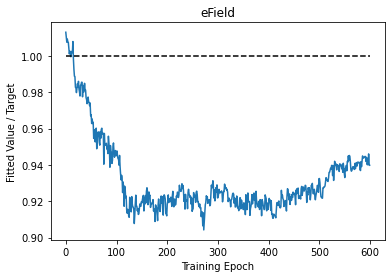

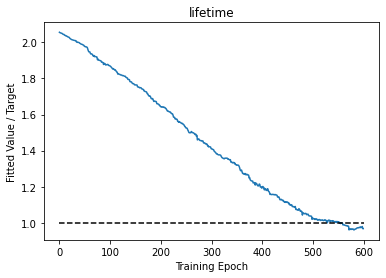

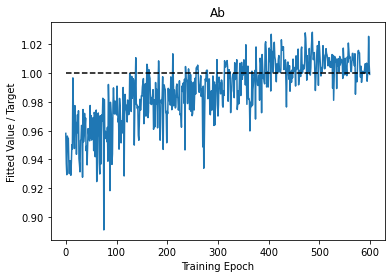

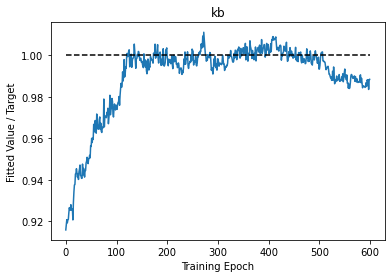

In [31]:
for param in relevant_params:
    plt.plot(np.asarray(training_step_track[param])*ranges[param]['nom']/getattr(sim_target, param))
    plt.plot([0, len(training_step_track[param])], [1, 1], c='k', ls='dashed')
    plt.ylabel('Fitted Value / Target')
    plt.title(param)
    plt.xlabel('Training Epoch')
    #plt.savefig(f'snapshot_{param}_with_normalize_1200.pdf')
    plt.show()

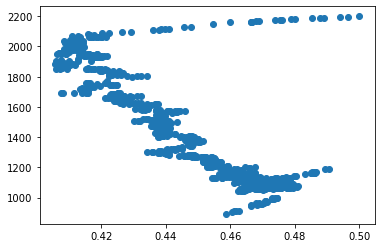

In [31]:
plt.scatter(np.asarray(training_step_track['eField'])*ranges['eField']['nom'],
            np.asarray(training_step_track['lifetime'])*ranges['lifetime']['nom']
           )